## 전이 학습
* 사전 학습된 네트워크의 가중치를 사용. 크게 세 가지
* 기본 과정 : 입력 -> 모델 -> 분류기 -> 출력
1. 모델을 변형하지 않고 사용
2. 모델 분류기 재학습
3. 모델 일부를 재학습시키기
* 전체 재학습은 시간이 많이 걸리므로 일부를 조정해서 이용한다.

170498071/170498071 [==============================] - 5s 0us/step


(35000, 1)

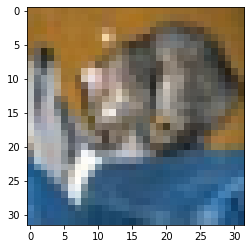

In [1]:
from keras.datasets import cifar10
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
plt.imshow(x_test[0])
x_mean = np.mean(x_train,axis=(0,1,2))
x_std = np.std(x_train, axis = (0,1,2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.3,random_state=777)
y_train.shape

In [4]:
x_train.shape

(35000, 32, 32, 3)

### 전이 학습 설정하기

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   zoom_range=0.2, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   rotation_range=30, 
                                   fill_mode='nearest') 

val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(x_train,y_train,batch_size=batch_size)
val_generator = val_datagen.flow(x_val,y_val,batch_size=batch_size)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam

from keras.applications import VGG16

vgg16 = VGG16(include_top=False,input_shape=(32, 32, 3))
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

### 모델 동결 해제하기

In [7]:
for layer in vgg16.layers[:-4]: # 모델 끝 4개 층만 선택
  layer.trainable = False # 동결을 해제제

### 전이 학습을 통해 학습하기

In [9]:
model = Sequential([
    vgg16,
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer = Adam(1e-4), loss = 'sparse_categorical_crossentropy',metrics=['acc'])

def get_step(train_len, batch_size):
  if(train_len % batch_size > 0):
    return train_len // batch_size + 1
  else:
    return train_len // batch_size

history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=get_step(len(x_train),batch_size),
                    validation_data=val_generator,
                    validation_steps = get_step(len(x_val), batch_size))

Epoch 1/100
1094/1094 [==============================] - 39s 27ms/step - loss: 1.1232 - acc: 0.1066 - val_loss: 0.9254 - val_acc: 0.0801
Epoch 2/100
1094/1094 [==============================] - 29s 27ms/step - loss: 0.9237 - acc: 0.1017 - val_loss: 1.0233 - val_acc: 0.0944
Epoch 3/100
1094/1094 [==============================] - 31s 28ms/step - loss: 0.8482 - acc: 0.1021 - val_loss: 0.7274 - val_acc: 0.1223
Epoch 4/100
1094/1094 [==============================] - 29s 26ms/step - loss: 0.7972 - acc: 0.1049 - val_loss: 0.7824 - val_acc: 0.0863
Epoch 5/100
1094/1094 [==============================] - 29s 26ms/step - loss: 0.7713 - acc: 0.1042 - val_loss: 0.7694 - val_acc: 0.0774
Epoch 6/100
1094/1094 [==============================] - 29s 26ms/step - loss: 0.7327 - acc: 0.1036 - val_loss: 0.7249 - val_acc: 0.0872
Epoch 7/100
1094/1094 [==============================] - 29s 26ms/step - loss: 0.7002 - acc: 0.1028 - val_loss: 0.7604 - val_acc: 0.0889
Epoch 8/100
1094/1094 [==================